### Covid-19 Prediction from Patients Chest X-ray's Image using CNN Deep Transfer Learning

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
import os
from glob import glob
import json
import os.path as osp
import sys
import math
from PIL import Image
import PIL.ImageDraw
import io
import shutil

In [3]:
keras.__version__

'2.3.1'

In [4]:
tf.__version__

'2.2.0'

In [0]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, auc,roc_curve,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
%cd "/content/drive/My Drive/COVID19/"

/content/drive/My Drive/COVID19


In [0]:
#Define hyperparameter variable which will be used later
img_size=150
nb_classes = 2  # number of classes
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 20  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

#1. Data Collection

Both COVID-19 and NORMAL patients X-ray image data has been collected from below given open source repository.

COVID-19 Dataset :  https://github.com/ieee8023/covid-chestxray-dataset <br>

  This dataset has chest X-ray & CT scan image of patients which are positive or suspected of COVID-19 or other viral and bacterial pneumonias (MERS, SARS, and ARDS.). This Data will be collected from public sources as well as through indirect collection from hospitals and physicians.

  From this dataset we have collected only COVID-19 positive patients chest X-ray image files. It has around 235 COVID-19 positive images and same downloaded into local folder.

NORMAL Dataset : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

  For NORMAL patient’s chest X-rays dataset has been collected from Kaggle. It has Normal and Pneumonia patient chest X-rays data. 
  From this dataset we have  collected 231 Normal patients X-ray images to make sure dataset are balanced with COVID-19 data.


This image files are collected into local folder as per below format,

        Dataset (Root Folder)
          -- COVID-19 (Sub-Folder)
          -- NORMAL  (Sub-Folder)

In [0]:
#In the GenerateDataSet method collect all image file path from COVID-19 and NORMAL folder and return as dataframe.
#In this dataframe, ImageName has file path and "Class" has label value 0 for NORMAL and 1 for COVID-19.
#Note : PNEUMONIA folder is not in use here
def GenerateDataSet(rootFolder):
    rows_list = []
    listOfFiles = os.listdir(rootFolder)
    for l in listOfFiles:
      if l=="PNEUMONIA":
        continue
      subFolder = rootFolder + "/" + l
      label=0
      if l == "COVID-19":
        label=1
      
      for label_file in glob(osp.join(subFolder, '*.*')):
        rows_list.append({'ImageName':label_file,'Class':label})
      
    return pd.DataFrame(rows_list)

In [0]:
#Get Dataset
df=GenerateDataSet("./Dataset")

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImageName  466 non-null    object
 1   Class      466 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.4+ KB


In [0]:
df.head()

,ImageName,Class
0,./Dataset/NORMAL/normal_001.jpeg,0
1,./Dataset/NORMAL/normal_003.jpeg,0
2,./Dataset/NORMAL/normal_004.jpeg,0
3,./Dataset/NORMAL/normal_002.jpeg,0
4,./Dataset/NORMAL/normal_007.jpeg,0


In the dataframe we have 466 files are there

#2. Exploratory  Data Analysis

In [0]:
df["Class"].value_counts()

1    235
0    231
Name: Class, dtype: int64

In [0]:
print("Total COVID-19 Class Count : ",df["Class"].value_counts()[1])
print("Total NORMAL Class Count : ",df["Class"].value_counts()[0])

Total COVID-19 Class Count :  235
Total NORMAL Class Count :  231


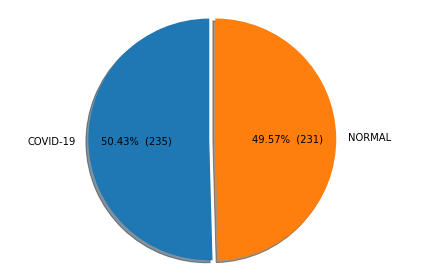

In [0]:
# Pie chart
labels = ['COVID-19', 'NORMAL']
sizes = [df["Class"].value_counts()[1], df["Class"].value_counts()[0]]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.05)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}%  ({p*sum(sizes)/100 :.0f})',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [0]:
covid_df=df[df["Class"]==1]
normal_df=df[df["Class"]==0]

## Sample picture from NORMAL patient X-ray Images

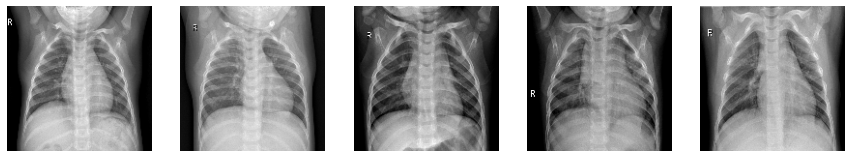

In [0]:
fig=plt.figure(figsize=(15, 15))

columns = 5
rows = 2
for i in range(1, 6):
    img = cv2.imread(normal_df.iloc[i].ImageName)
    img = cv2.resize(img, (img_size, img_size))
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

### Sample picture from COVID-19 positive patient X-ray Images

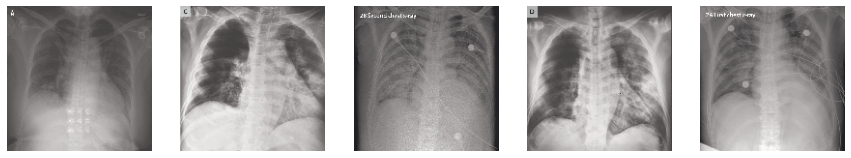

In [0]:

fig=plt.figure(figsize=(15, 15))

columns = 5
rows = 2
for i in range(1, 6):
    img = cv2.imread(covid_df.iloc[i].ImageName)
    img = cv2.resize(img, (img_size, img_size))
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

#3. Data Pre-Processing


In the data pre-processing stage we are do below given step to split, resize and normalize the data for modelling.


1.   Randomly Split image file dataset to Train (90%) and Test (10%).
2.   In the image pre-processing method, its get image bytes from file and resize to 150x150.
3. And then it will Normalize the image to 0-1 from 0-255.
4. Finally this method return numpy array object as X and corresponding label value as Y.
5. Invoke imagePreProcess method with train_df and get the X & Y values.
6. Randomly split X&Y value as Actual Train and Validation dataset.



In [0]:
msk = np.random.rand(len(df)) < 0.80
train_df = df[msk]
test_df = df[~msk]

In [71]:
train_df.shape

(373, 2)

In [72]:
test_df.shape

(93, 2)

In [0]:
#This method used for pre-proceesing data from dataframe before modelling for Train and same will be used for Validate and Test data set.
#This method return image normalized data in numpy array format as X and corresponding label value in Y.
def imagePreProcess(data):
  X=[]
  Y=[]
  for i in data.itertuples():
    #Read image from physical file using Open CV
    img_arr = cv2.imread(i[1])
    #Resize image bytes to 150x150
    resized_arr = cv2.resize(img_arr, (img_size, img_size))
    X.append(resized_arr)
    Y.append(i[2])
  #Normalize the image data to 0-1 from 0-255 
  X=np.array(X)/255
  return X, np.array(Y)





In [0]:
X,y=imagePreProcess(train_df)

In [74]:
X.shape

(373, 150, 150, 3)

In [0]:
test_size = 0.20 # taking 80:20 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

In [0]:
X_test,y_test=imagePreProcess(test_df)

In [77]:
print("Total Data Count :",len(df["Class"]))
print("Total Train Data Count :",len(X_train))
print("Total Validation Data Count :",len(X_val))
print("Total Test Data Count :",len(X_test))

Total Data Count : 466
Total Train Data Count : 298
Total Validation Data Count : 75
Total Test Data Count : 93


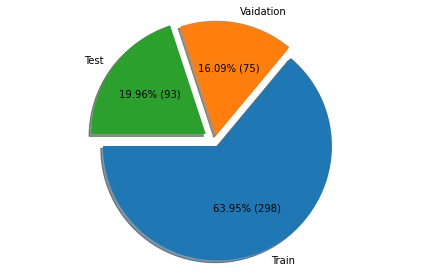

In [78]:
# Pie chart
labels = ['Train','Vaidation', 'Test']
sizes = [len(X_train), len(X_val),len(X_test)]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.05, 0.05,0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda p:f'{p:.2f}% ({p*sum(sizes)/100 :.0f})',
        shadow=True, startangle=180)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Deep Learning Image Binary Classification Model:

Here we will be using Xception model base architecture with transfer learning technique to predict COVID-19.

### ResNet50 Model

ResNet50 Paper Reference : https://arxiv.org/abs/1512.03385

In [0]:
base_ResNet50_Model=tf.keras.applications.ResNet50(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
# Top Model Block
x = base_ResNet50_Model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [0]:
# add your top layer block to your base model
resNet50_model = tf.keras.models.Model(base_ResNet50_Model.input, predictions)

In [0]:
resNet50_model.compile(optimizer='nadam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './resNet50_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)
]

In [0]:
# Train the Xception Model for 10 epochs with train and validation data.
#Using callback function we are adding Model checkpoint to save best model in each epoch 
#And doing early stopping the training to stop model overfitting.
resNet50_history=resNet50_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=nb_epoch,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9552
Epoch 00001: val_loss improved from inf to 60.93299, saving model to ./resNet50_Best_model.h5
11/11 [==============================] - 111s 10s/step - loss: 0.0671 - accuracy: 0.9552 - val_loss: 60.9330 - val_accuracy: 0.5238
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9612
Epoch 00002: val_loss did not improve from 60.93299
11/11 [==============================] - 107s 10s/step - loss: 0.1688 - accuracy: 0.9612 - val_loss: 881252.1875 - val_accuracy: 0.5238
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9970
Epoch 00003: val_loss did not improve from 60.93299
11/11 [==============================] - 108s 10s/step - loss: 0.0147 - accuracy: 0.9970 - val_loss: 1774.9065 - val_accuracy: 0.5238
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 3.0294e-04 - accuracy: 1.0000
Epoch 00004: val_los

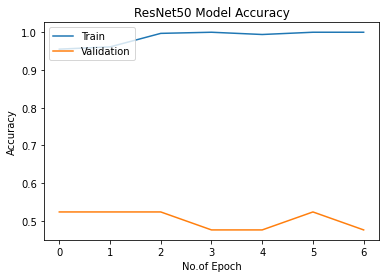

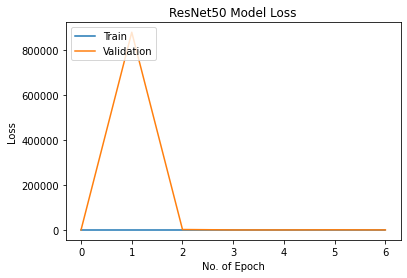

In [0]:
plt.plot(resNet50_history.history['accuracy'])
plt.plot(resNet50_history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resNet50_history.history['loss'])
plt.plot(resNet50_history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Xception Model :


Xception Reference : https://arxiv.org/abs/1610.02357


In [0]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_xception_model = tf.keras.applications.Xception(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

In [0]:
#Set pre-trained model layers to not trainable
#for layer in base_xception_model.layers:
   # layer.trainable = False

In [0]:
# Top Model Block
x = base_xception_model.output
#x=tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [0]:
# add your top layer block to your base model
xception_model = tf.keras.models.Model(base_xception_model.input, predictions)


In [0]:
xception_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

In [83]:
xception_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './xception_Final_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

In [85]:
# Train the Xception Model for 10 epochs with train and validation data.
#Using callback function we are adding Model checkpoint to save best model in each epoch 
#And doing early stopping the training to stop model overfitting.
xception_history=xception_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=10,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9161 
Epoch 00001: val_loss improved from inf to 2.47062, saving model to ./xception_Final_Best_model.h5
10/10 [==============================] - 108s 11s/step - loss: 0.1755 - accuracy: 0.9161 - val_loss: 2.4706 - val_accuracy: 0.8267
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9933 
Epoch 00002: val_loss improved from 2.47062 to 0.97182, saving model to ./xception_Final_Best_model.h5
10/10 [==============================] - 107s 11s/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.9718 - val_accuracy: 0.8933
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9966 
Epoch 00003: val_loss improved from 0.97182 to 0.12566, saving model to ./xception_Final_Best_model.h5
10/10 [==============================] - 107s 11s/step - loss: 0.0200 - accuracy: 0.9966 - val_loss: 0.1257 - val_accuracy: 0.9867
Epoch 4/10
10/10 

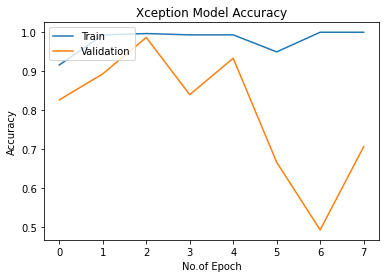

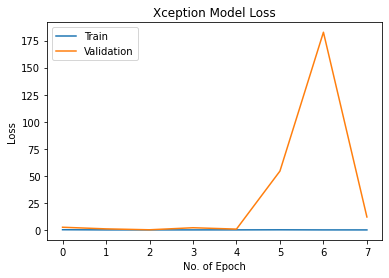

In [86]:
plt.plot(xception_history.history['accuracy'])
plt.plot(xception_history.history['val_accuracy'])
plt.title('Xception Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('Xception Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### InceptionV3
InceptionV3 Reference Paper : https://arxiv.org/abs/1512.03385

In [87]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_InceptionV3_model = tf.keras.applications.InceptionV3(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)
# Top Model Block
x = base_InceptionV3_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# add your top layer block to your base model
InceptionV3_model = tf.keras.models.Model(base_InceptionV3_model.input, predictions)
InceptionV3_model.compile(optimizer='nadam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './InceptionV3_Final_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

In [89]:
Inception_history=InceptionV3_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=10,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.8993
Epoch 00001: val_loss improved from inf to 0.06546, saving model to ./InceptionV3_Final_Best_model.h5
10/10 [==============================] - 63s 6s/step - loss: 0.2550 - accuracy: 0.8993 - val_loss: 0.0655 - val_accuracy: 0.9733
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000
Epoch 00002: val_loss did not improve from 0.06546
10/10 [==============================] - 58s 6s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.2442 - val_accuracy: 0.9200
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.9262
Epoch 00003: val_loss improved from 0.06546 to 0.05469, saving model to ./InceptionV3_Final_Best_model.h5
10/10 [==============================] - 60s 6s/step - loss: 0.2275 - accuracy: 0.9262 - val_loss: 0.0547 - val_accuracy: 0.9733
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.01

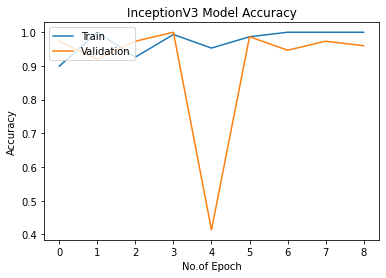

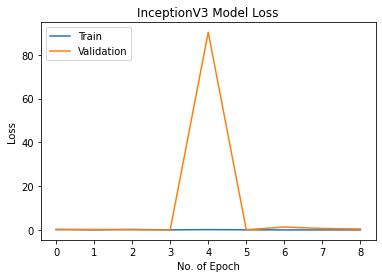

In [90]:
plt.plot(Inception_history.history['accuracy'])
plt.plot(Inception_history.history['val_accuracy'])
plt.title('InceptionV3 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(Inception_history.history['loss'])
plt.plot(Inception_history.history['val_loss'])
plt.title('InceptionV3 Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### DenseNet201 Model :

DenseNet201 Reference Paper : https://arxiv.org/abs/1608.06993 

In [0]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_Densenet201_model = tf.keras.applications.DenseNet121(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)
# Top Model Block
x = base_Densenet201_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# add your top layer block to your base model
DenseNet201_model = tf.keras.models.Model(base_Densenet201_model.input, predictions)
DenseNet201_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # categorical_crossentropy if multi-class classifier
              metrics=['accuracy'])

In [0]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = './DenseNet201_Final_Best_model.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, verbose=1, save_best_only=True,),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
]

In [107]:
DenseNet201_history=DenseNet201_model.fit(X_train,y_train, 
                                    validation_data=( X_val , y_val ),
                                    epochs=10,
                                    batch_size=batch_size,
                                    callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9295
Epoch 00001: val_loss improved from inf to 0.70635, saving model to ./DenseNet201_Final_Best_model.h5
10/10 [==============================] - 93s 9s/step - loss: 0.1181 - accuracy: 0.9295 - val_loss: 0.7063 - val_accuracy: 0.7733
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9866
Epoch 00002: val_loss improved from 0.70635 to 0.59022, saving model to ./DenseNet201_Final_Best_model.h5
10/10 [==============================] - 92s 9s/step - loss: 0.0219 - accuracy: 0.9866 - val_loss: 0.5902 - val_accuracy: 0.8400
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9899
Epoch 00003: val_loss did not improve from 0.59022
10/10 [==============================] - 89s 9s/step - loss: 0.0147 - accuracy: 0.9899 - val_loss: 15.8826 - val_accuracy: 0.6000
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0

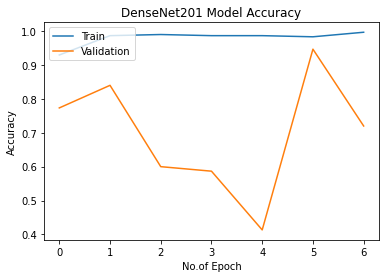

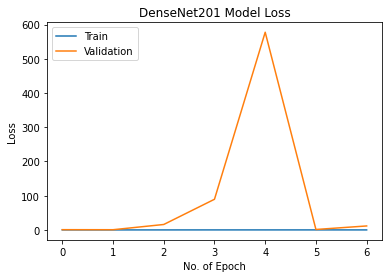

In [108]:
plt.plot(DenseNet201_history.history['accuracy'])
plt.plot(DenseNet201_history.history['val_accuracy'])
plt.title('DenseNet201 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No.of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(DenseNet201_history.history['loss'])
plt.plot(DenseNet201_history.history['val_loss'])
plt.title('DenseNet201 Model Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model Prediction Using Test Data

In [0]:
def model_Prediction(model_Name,model_FilePath,x_Feature,true_Label):
  #Load trained best model file (.h5) from loacal folder
  model=tf.keras.models.load_model(model_FilePath)
  #Modelprediction
  predictions = model.predict(x_Feature)
  predicted_label=[]
  #
  for i in predictions:
    if(i[0] > 0.5):
      predicted_label.append(1)
    else:
      predicted_label.append(0)
  
  predicted_label=np.array(predicted_label)
  #Calculate Accuracy
  accuracy=float(format(accuracy_score(true_Label,predicted_label),'.2f'))
  #Calculate Recall
  recall=float(format(recall_score(true_Label,predicted_label),'.2f'))
  #Calcuate Precision
  precision=float(format(precision_score(true_Label,predicted_label),'.2f'))
  #Calculate F1-Score
  f1score=float(format(f1_score(true_Label,predicted_label),'.2f'))
  #Get Confusion matrix between true lable and predicted label
  CM = confusion_matrix(true_Label, predicted_label)
  result={'ModelName':model_Name,'Accuracy':accuracy,'Recall':recall,'Precision':precision,'F1_Score':f1score}
  #Retrun result metrics report and Confusion Matrix
  return result,CM


In [0]:
#Predict test data with Xception Model
xception_Result,xceptionModel_CM=model_Prediction("Xception",'./xception_Final_Best_model.h5',X_test,y_test)

In [0]:
#Predict test data with InceptionV3 Model
InceptionV3_Result,InceptionV3_CM=model_Prediction("InceptionV3",'./InceptionV3_Final_Best_model.h5',X_test,y_test)

In [0]:

#Predict test data with ResNet 50 Model
resNet50_Result,resNet50_CM=model_Prediction("ResNet50",'./resNet50_Best_model.h5',X_test,y_test)

In [0]:
#Predict test data with DenseNet 201 Model
denseNet201_Result,denseNet201_CM=model_Prediction("DenseNet201",'./DenseNet201_Final_Best_model.h5',X_test,y_test)

In [0]:
result=[]
result.append(xception_Result)
result.append(InceptionV3_Result)
result.append(denseNet201_Result)
result.append(resNet50_Result)

result=pd.DataFrame(result)

In [118]:
result

,ModelName,Accuracy,Recall,Precision,F1_Score
0,Xception,0.99,0.98,1.00,0.99
1,InceptionV3,0.98,0.96,1.00,0.98
2,DenseNet201,0.87,0.98,0.83,0.90
3,ResNet50,0.57,1.00,0.57,0.73


### Xception Model - Test Data Confusion Matrix

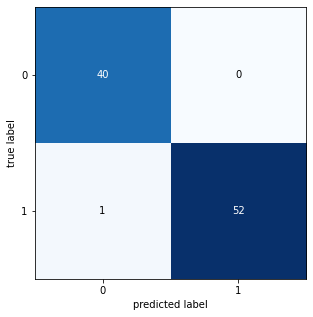

In [119]:
fig, ax = plot_confusion_matrix(conf_mat=xceptionModel_CM ,  figsize=(5, 5))
plt.show()

### InceptionV3 Model - Test Data Confusion Matrix

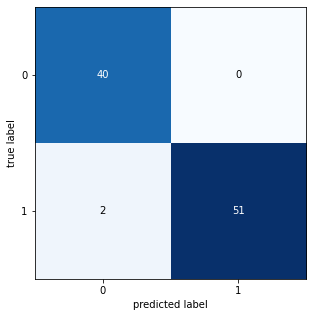

In [115]:
fig, ax = plot_confusion_matrix(conf_mat=InceptionV3_CM ,  figsize=(5, 5))
plt.show()

# Final Summary


	 
*   From  gievn dataset full population (# 466), we have taken 298 for model  training, 75 for validation and 93 for final testing.
*   We have built below listed Deep Transfer Learning model to predict COVID-19 from Patient's chest X-ray image and from this testing we able to see Xception and InceptionV3 model giving higher accuracy for this dataset.

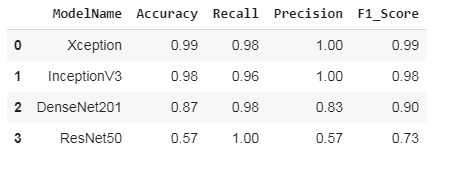

*   But due to very less amount of data we able to see our model is overfitting.


